# > Desafio
Integrantes: \
                 -Hugo Rocha -- 201610531-K \
                 -Gabriel Vergara -- 201510519-7

Equipo: RNG

[Video de la defensa](https://youtu.be/Lo9bp2NuXZQ)

El presente es un trabajo original, desarrollado por los autores en conformidad con todas reglas de codigo de honor y honestidad. Sumado a esto ultimo 
se deja en claro que la contribucion de ambos participantes en el presente trabajo fue la siguiente:

Gabriel Vergara:\
-Exploratorio. \
-Testeo inicial modelos de regresion. 
                 
Hugo Rocha:      
-preprocesamiento. \
-Cross Validation para elecciond e modelos y parametros. 

Ambos trabajamos de manera colaborativa en la formulacion de las conclusiones obtenidas en el presente trabajo.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import re

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


import scipy.stats as stats
from scipy.stats import kurtosis,skew
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

In [2]:
def rankear_hoteles(hotel_details):
    lista = []
    for i in hotel_details:
        hoteles = i.split('|')
        aux = []
        aux2 = []
        for j in range(len(hoteles)):
            if hoteles[0] != 'Not Available':
                aux.append(hoteles[j].split(':')[1])
                aux2.append(hoteles[j].split(':')[0])
        lista.append([aux2,aux])
    hoteles_todos = []
    scores_todos = []
    for i in lista:
        hoteles_todos = [*hoteles_todos,*i[0]]
        scores_todos = [*scores_todos,*i[1]]
    d = {'hoteles': hoteles_todos, 'scores': scores_todos}
    df = pd.DataFrame(data=d)
    hoteles_unicos = df['hoteles'].unique()
    score = []
    for i in range(len(hoteles_unicos)):
        hotel_idx = df['hoteles'] == hoteles_unicos[i]
        n = np.mean(pd.to_numeric(df[hotel_idx]['scores']))
        score.append(n)
    hotel_rank = {'hotel': hoteles_unicos, 'scores': score}
    Hotel_rank = pd.DataFrame(data=hotel_rank)  
    media = np.mean(Hotel_rank['scores'])
    Hotel_rank['scores'] = Hotel_rank['scores'].replace(np.nan, media)
    return Hotel_rank
def hotel_rank_mean(hotel_details,Hotel_rank):
    hoteles = hotel_details.split('|')
    hoteles
    aux = []
    for j in range(len(hoteles)):
        if hoteles[0] != 'Not Available':
            aux.append(hoteles[j].split(':')[0])       
    valores = []
    for i in range(len(aux)):
        valores.append(Hotel_rank[ Hotel_rank['hotel'] == aux[i]]['scores'])
    return np.mean(valores) 
def noches(itinerario):
    u=itinerario.split('. ')
    n = 0
    for j in range(len(u)):
        n = n + float(u[j].split('N')[0])
    return n  
def noches_ponderadas(itinerario,hotel_details,Hotel_rank):
    u=itinerario.split('. ')
    n = 0
    hoteles = hotel_details.split('|')
    aux = []
    #print(u)
    #print(hoteles)
    for j in range(len(hoteles)):
        if hoteles[0] != 'Not Available':
            aux.append(hoteles[j].split(':')[0])       
    valores = []
    for i in range(len(aux)):
        valores.append(Hotel_rank[ Hotel_rank['hotel'] == aux[i]]['scores'])
     
    if valores == []:
        valores = np.mean(Hotel_rank['scores'])
        for j in range(len(u)):
            n = n + float(u[j].split('N')[0])*valores
    else:
        if len(u) == len(valores):
            for j in range(len(u)):
                #print(u[j].split('N')[0])
                #print(valores[j])
                #print(float(u[j].split('N')[0])*valores[j])
                n = n + float(float(u[j].split('N')[0])*valores[j])
        else:
            #print(valores[0])
            #print(u)
            for j in range(len(u)):
                #print(u[j].split('N')[0])
                #print(valores[j])
                #print(float(u[j].split('N')[0])*valores[j])
                n = n + float(float(u[j].split('N')[0])*valores[0])
                #j
    return   n
def dest_numb(destinos):
    d=destinos.split(sep='|')
    return len(d)
def mes(Travel_Date):
    d=Travel_Date.split(sep='-')
    return d[1]
def ano(Travel_Date):
    d=Travel_Date.split(sep='-')
    return d[2]
def paquete_numero(paquetes):
    aux = paquetes
    aux = aux.apply(lambda x: x.replace("Budget", "0"))
    aux = aux.apply(lambda x: x.replace("Standard", "1"))
    aux = aux.apply(lambda x: x.replace("Deluxe", "1"))
    aux = aux.apply(lambda x: x.replace("Luxury", "2"))
    aux = aux.apply(lambda x: x.replace("Premium", "2"))
    return aux

def destinos(destinos):
    lista_destinos = []
    for i in destinos:
        destino = i.split('|')
        for j in range(len(destino)):
            if destino[0] != 'Not Available':
                lista_destinos.append(destino[j])
    d = {'destino': lista_destinos}
    df = pd.DataFrame(data=d)
    destinos_unicos = df['destino'].unique()
    return destinos_unicos

def obtener_destinos(destino, Destinos):
    destino = destino.split('|')
    #print(destino)
    aux = np.zeros(len(Destinos)).astype(int)
    for i in range(len(destino)):
        
        aux = aux + (Destinos == destino[i]).astype(int)
    #d = {Destinos: aux}
    #df = pd.DataFrame(data=d)    
    return  aux   #pd.Series(aux,index=Destinos)    

def todos_destinos(total_destinos):
    lista = []
    Destinos = destinos(total_destinos)
    for i in total_destinos:
        lista.append(obtener_destinos(i, Destinos))
    ddf = pd.DataFrame(lista)
    ddf.columns = Destinos
    return ddf

def regla_cancelacion(Cancellation_Rules):
    indice = Cancellation_Rules.unique()
    Cancellation_Rules.replace({indice[0]: "Rule 1", "b": "y",
                                         indice[1]: "Rule 2",
                                         indice[2]: "Rule 3",
                                         indice[3]: "Rule 4",
                                         indice[4]: "Rule 5",
                                         indice[5]: "Rule 6",
                                         indice[6]: "Rule 7",
                                         indice[7]: "Rule 8",}, inplace=True)
    return Cancellation_Rules 

def areglo_hoteles(Hotel_Details):
    Hotel_Details = Hotel_Details.apply(lambda x: x.replace("Four", "4"))
    Hotel_Details = Hotel_Details.apply(lambda x: x.replace("Two", "2"))
    Hotel_Details = Hotel_Details.apply(lambda x: x.replace("Three", "3"))
    Hotel_Details = Hotel_Details.apply(lambda x: x.replace("Five", "5"))
    Hotel_Details = Hotel_Details.apply(lambda x: x.replace("The Lodhi:A member of The Leading Hotels Of The World", "The Lodhi"))
    return Hotel_Details

In [3]:
def procesar_data(data_train):
    data_train['Cancellation Rules'] = regla_cancelacion(data_train['Cancellation Rules'])
    data_train['Hotel Details'] = areglo_hoteles(data_train['Hotel Details'])
    
    Hotel_rank = rankear_hoteles(data_train['Hotel Details'])
    data_train['total_noches'] = data_train['Itinerary'].apply(lambda row: noches(row))
    data_train['hotel_qual_prom'] = data_train['Hotel Details'].apply(lambda row: hotel_rank_mean(row,Hotel_rank))
    data_train['noches_pond_hotel'] = data_train.apply(lambda x: noches_ponderadas(x['Itinerary'], x['Hotel Details'],Hotel_rank), axis=1)
    data_train['dest_numb'] = data_train['Destination'].apply(lambda row: dest_numb(row))
    
    data_train['mes'] = data_train['Travel Date'].apply(lambda row: mes(row))
    data_train['ano'] = data_train['Travel Date'].apply(lambda row: ano(row))
    
    data_train['paquete'] = data_train['Package Type']
    data_train['paquete'] = data_train['paquete'].apply(lambda x: x.replace("Luxury", "Premium"))
    data_train['paquete'] = data_train['paquete'].apply(lambda x: x.replace("Deluxe", "Standard"))
    
    data_train['Quarter'] = pd.to_datetime(data_train['Travel Date'].values, format='%d-%m-%Y').astype('period[Q]')
    data_train['Quarter']= data_train['Quarter'].astype(str).apply(lambda x: x.replace("2021", ""))
    data_train['Quarter'] = data_train['Quarter'].astype(str).apply(lambda x: x.replace("2022", ""))
    # creando dummies
    Package_Type=pd.get_dummies(data_train['paquete'])
    Cancellation_Rules=pd.get_dummies(data_train['Cancellation Rules'])
    Ciudades = pd.get_dummies(data_train['Start City'])
    Años = pd.get_dummies(data_train['ano'])
    Quarter = pd.get_dummies(data_train['Quarter'])

    media = np.mean(Hotel_rank['scores'])
    data_train['hotel_qual_prom'] = data_train['hotel_qual_prom'].fillna(media)
    
    Destinos = todos_destinos(data_train['Destination'])
    paquete_numeros = paquete_numero(data_train['Package Type'])
    Sightseeing = todos_destinos(data_train['Sightseeing Places Covered']) # altamente dimensional
    
    #data_train=data_train.drop(['Unnamed: 0','Itinerary','Destination',
    #                            'Package Name','Places Covered',
    #                            'Travel Date','Hotel Details','Start City',
    #                            'Airline','Sightseeing Places Covered',
    #                            'Package Type','Cancellation Rules',
    #                            'mes','ano','Quarter','paquete',
    #                              ],axis=1)
    
    
    data_train = pd.concat([data_train, Package_Type,Cancellation_Rules,
                            Años,Quarter,paquete_numeros, 
                            Destinos,Sightseeing], axis=1, join="inner")  #,Sightseeing
    return data_train,Destinos,Sightseeing

In [4]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

def box_cox(y,lam):
    if lam == 0:
        return np.log(y)
    else:
        return (y**lam-1)/lam
    
def inv_box_cox(y,l):
    if l == 0:
        return np.exp(y)
    else:
        return (y*l+1)**(1/l)  

In [5]:
data_train = pd.read_csv("travel_packages_train.csv")
data_test = pd.read_csv("travel_packages_test.csv")

# Procesar Data


In [6]:
datos_train,destinos_train,Sightseeing_train = procesar_data(data_train)
datos_test,destinos_test,Sightseeing_test = procesar_data(data_test)

In [7]:
# para dar formato al test
train_aux = destinos_train*0
train_aux[destinos_test.columns] = destinos_test
train_aux= train_aux[0:datos_test.shape[0]]
datos_test = datos_test.drop(list(destinos_test.columns), axis = 1)
datos_test = pd.concat([datos_test,train_aux], axis=1, join="inner")

In [8]:
# para dar formato al test
train_aux = Sightseeing_train*0
train_aux[Sightseeing_test.columns] = Sightseeing_test
train_aux= train_aux[0:datos_test.shape[0]]
datos_test = datos_test.drop(list(Sightseeing_test.columns), axis = 1)
datos_test = pd.concat([datos_test,train_aux], axis=1, join="inner")

# Exploratorio

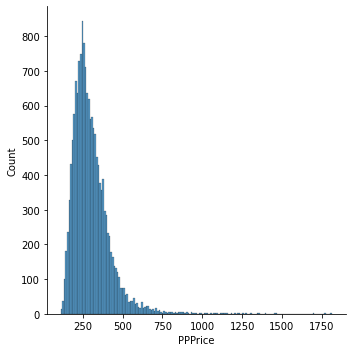

In [9]:
sns.displot(data_train, x="PPPrice")

In [10]:
print( 'excess kurtosis of normal distribution (should be 0): {}'.format( kurtosis(data_train['PPPrice']) ))
print( 'skewness of normal distribution (should be 0): {}'.format( skew(data_train['PPPrice']) ))

excess kurtosis of normal distribution (should be 0): 14.229623978989736
skewness of normal distribution (should be 0): 2.481661602217295


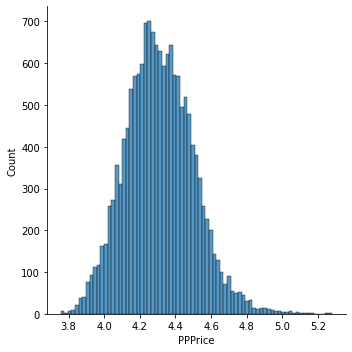

In [11]:
sns.displot(box_cox(data_train['PPPrice'],-0.1))

In [12]:
print( 'excess kurtosis of normal distribution (should be 0): {}'.format( kurtosis(box_cox(data_train['PPPrice'],-0.1)) ))
print( 'skewness of normal distribution (should be 0): {}'.format( skew(box_cox(data_train['PPPrice'],-0.1)) ))

excess kurtosis of normal distribution (should be 0): 0.45748615396234316
skewness of normal distribution (should be 0): 0.3377752260163218


<AxesSubplot:title={'center':'PPPrice'}, xlabel='dest_numb'>

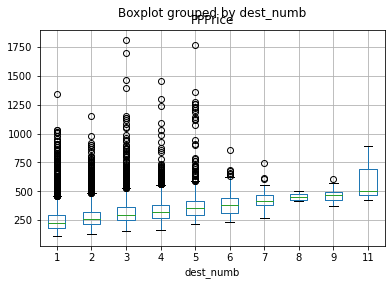

In [13]:
data_train.boxplot(column=['PPPrice'],by="dest_numb")

<AxesSubplot:title={'center':'PPPrice'}, xlabel='total_noches'>

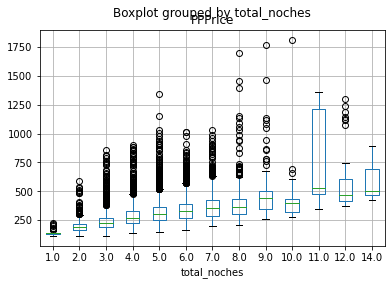

In [14]:
data_train.boxplot(column=['PPPrice'],by="total_noches")

<AxesSubplot:title={'center':'PPPrice'}, xlabel='Package Type'>

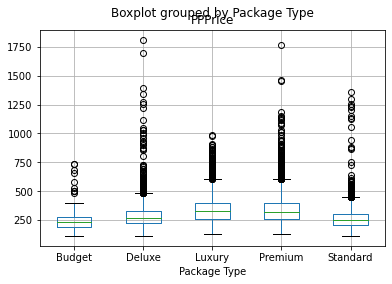

In [15]:
data_train.boxplot(column=['PPPrice'],by="Package Type")

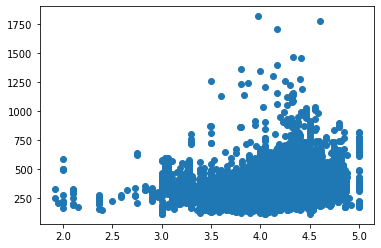

In [16]:
plt.scatter(data_train['hotel_qual_prom'],data_train['PPPrice'])

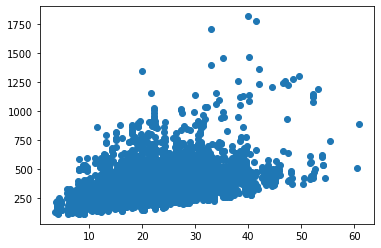

In [17]:
plt.scatter(data_train['noches_pond_hotel'],data_train['PPPrice'])

<AxesSubplot:title={'center':'PPPrice'}, xlabel='Package Type'>

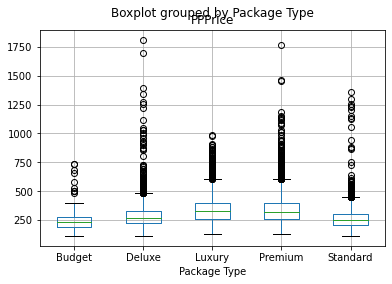

In [97]:
data_train.boxplot(column=['PPPrice'],by="Package Type")

<AxesSubplot:title={'center':'PPPrice'}, xlabel='paquete'>

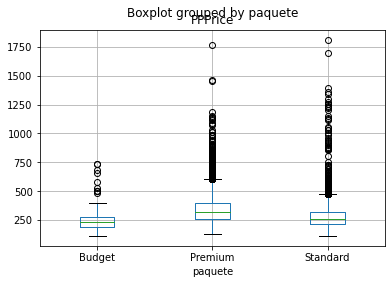

In [98]:
data_train.boxplot(column=['PPPrice'],by="paquete")

<AxesSubplot:title={'center':'PPPrice'}, xlabel='ano'>

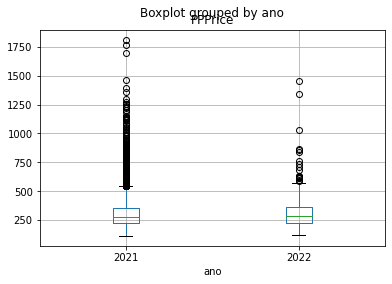

In [99]:
data_train.boxplot(column=['PPPrice'],by="ano")

<AxesSubplot:title={'center':'PPPrice'}, xlabel='mes'>

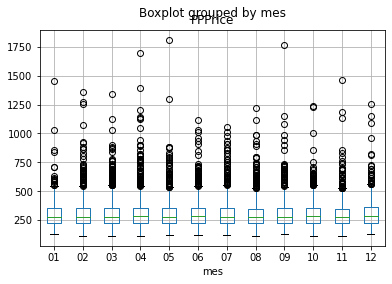

In [100]:
data_train.boxplot(column=['PPPrice'],by="mes")

<AxesSubplot:title={'center':'PPPrice'}, xlabel='Quarter'>

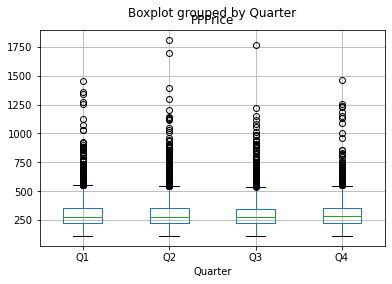

In [101]:
data_train.boxplot(column=['PPPrice'],by="Quarter")

# Entrenamiento

In [102]:
datos_train=datos_train.drop(['Unnamed: 0','Itinerary','Destination',
                            'Package Name','Places Covered',
                            'Travel Date','Hotel Details','Start City',
                            'Airline',
                            'Package Type','Cancellation Rules','Quarter','paquete',
                              ],axis=1)
datos_train

,Flight Stops,Meals,Sightseeing Places Covered,PPPrice,total_noches,hotel_qual_prom,noches_pond_hotel,dest_numb,mes,ano,...,Wine Tasting Tour with Dinner/Lunch (With Transfers),Saputara Lake,Dandi Beach,Parnera hill temple,Devka Beach,Gwalior fort,Vishnu temple,Ram Raja Temple,Chaturbhuj Temple,"Private Transfer - Changi Airport to Any Hotel, Harbour Front or Bus Station in Singapore"
0,1,3,Singhik View Point | Chungthang | Yumthang Va...,284.0,4.0,4.044395,15.928740,3,01,2022,...,0,0,0,0,0,0,0,0,0,0
1,2,2,Har Ki Pauri,129.0,2.0,4.052135,8.104271,1,11,2021,...,0,0,0,0,0,0,0,0,0,0
2,0,5,Hanwant Mahal | Candlelight Dinner in Jodhpur...,311.0,4.0,4.464060,17.856241,2,08,2021,...,0,0,0,0,0,0,0,0,0,0
3,0,5,Simtokha Dzong | Memorial Chorten | Buddha Do...,517.0,5.0,4.500000,22.500000,2,02,2021,...,0,0,0,0,0,0,0,0,0,0
4,1,3,Changu Lake - Excursion | Baba Mandir | Tashi...,336.0,5.0,4.239318,21.257646,3,06,2021,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15745,1,3,Fort Cochin | Dutch Palace | Jewish Synagogue...,245.0,7.0,3.932804,27.452412,5,08,2021,...,0,0,0,0,0,0,0,0,0,0
15746,2,3,Not Available,352.0,5.0,3.557318,17.291771,2,05,2021,...,0,0,0,0,0,0,0,0,0,0
15747,0,4,MMT - Candid Photographer in Goa,223.0,2.0,4.139583,8.279167,1,04,2021,...,0,0,0,0,0,0,0,0,0,0
15748,2,3,Half Day Temples City Tour and Shopping at Je...,385.0,7.0,3.661406,26.195707,3,07,2021,...,0,0,0,0,0,0,0,0,0,0


In [103]:
datos=datos_train.drop(['Meals','Sightseeing Places Covered','ano','mes','hotel_qual_prom','Rule 2','Rule 3',
                           'Rule 4','Rule 5','Rule 6','Rule 7',
                           'Rule 8','2021','Q1','Q2','Q3',#' Gwalior fort ',
                           'Budget'],axis=1)
datos

,Flight Stops,PPPrice,total_noches,noches_pond_hotel,dest_numb,Premium,Standard,Rule 1,2022,Q4,...,Wine Tasting Tour with Dinner/Lunch (With Transfers),Saputara Lake,Dandi Beach,Parnera hill temple,Devka Beach,Gwalior fort,Vishnu temple,Ram Raja Temple,Chaturbhuj Temple,"Private Transfer - Changi Airport to Any Hotel, Harbour Front or Bus Station in Singapore"
0,1,284.0,4.0,15.928740,3,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,129.0,2.0,8.104271,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,311.0,4.0,17.856241,2,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,517.0,5.0,22.500000,2,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,336.0,5.0,21.257646,3,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15745,1,245.0,7.0,27.452412,5,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
15746,2,352.0,5.0,17.291771,2,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
15747,0,223.0,2.0,8.279167,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15748,2,385.0,7.0,26.195707,3,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [104]:
datos['dest_num_square']=datos['dest_numb']**2

In [105]:
datos['total_noches_sqr']=(datos['total_noches'])**(1/2)

In [106]:
datos['noches_pond_hotel_log']=np.log(datos['noches_pond_hotel'])

In [107]:
y = datos['PPPrice']
X = datos.drop(['PPPrice',' Gwalior fort '], axis=1)
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2, random_state=44)

## Prueba de modelos

### OLS

In [108]:
XX =  datos.drop(['PPPrice','Q4'], axis=1)#,Sightseeing_train.columns 
listas = list(set(list(Sightseeing_train.columns)) )
XX = XX.drop(listas, axis = 1)
XX_train, XX_val, yy_train, yy_val = train_test_split(XX,y,test_size=0.2, random_state=44)
reg = LinearRegression().fit(XX_train, yy_train)
yy_pred = reg.predict(XX_val)
mape(yy_val,yy_pred)

13.975516205284718

excess kurtosis of normal distribution (should be 0): 18.16139464517143
skewness of normal distribution (should be 0): 2.270804720936949


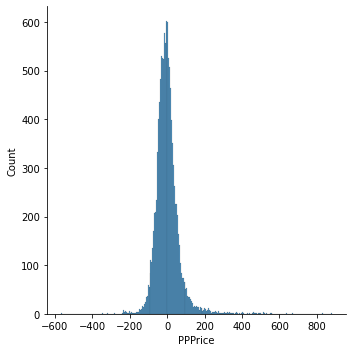

In [109]:
residuos = yy_train - reg.predict(XX_train)
sns.displot(residuos)
print( 'excess kurtosis of normal distribution (should be 0): {}'.format( kurtosis(residuos) ))
print( 'skewness of normal distribution (should be 0): {}'.format( skew(residuos) ))

In [ ]:
shapiro_test = stats.shapiro(residuos)
shapiro_test

#### box.cox-ols



In [111]:
l = -0.1
reg_cox = LinearRegression().fit(X_train, box_cox(y_train,l))
y_pred = reg_cox.predict(X_val)
mape(y_val,inv_box_cox(y_pred,l))

11.934494370571922

excess kurtosis of normal distribution (should be 0): 3.5849931836391837
skewness of normal distribution (should be 0): 0.8078665973055486


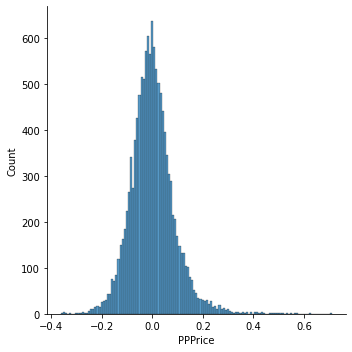

In [112]:
residuos = box_cox(y_train,l) - reg_cox.predict(X_train)
sns.displot(residuos)
print( 'excess kurtosis of normal distribution (should be 0): {}'.format( kurtosis(residuos) ))
print( 'skewness of normal distribution (should be 0): {}'.format( skew(residuos) ))

### LASSO

In [68]:
from sklearn.linear_model import Lasso
model = Lasso(alpha= 1)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
mape(y_val,y_pred)

16.54483817265279

excess kurtosis of normal distribution (should be 0): 15.84776494539123
skewness of normal distribution (should be 0): 2.1634124297475


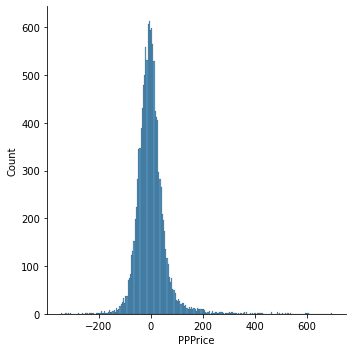

In [113]:
residuos = y_train - model.predict(X_train)
sns.displot(residuos)
print( 'excess kurtosis of normal distribution (should be 0): {}'.format( kurtosis(residuos) ))
print( 'skewness of normal distribution (should be 0): {}'.format( skew(residuos) ))

#### box-cox-lasso

In [114]:
l = -0.1
model_cox = Lasso(alpha=0.01)
model.fit(X_train, box_cox(y_train,l))
y_pred = model.predict(X_val)
mape(y_val,inv_box_cox(y_pred,l))

11.772313186451017

excess kurtosis of normal distribution (should be 0): 3.5495519625844345
skewness of normal distribution (should be 0): 0.8025557469981238


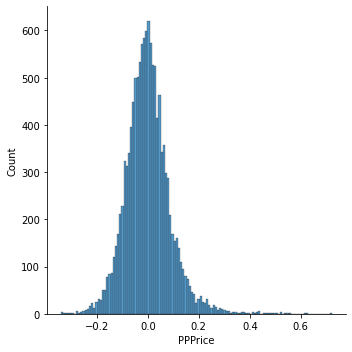

In [115]:
residuos = box_cox(y_train,l) - model.predict(X_train)
sns.displot(residuos)
print( 'excess kurtosis of normal distribution (should be 0): {}'.format( kurtosis(residuos) ))
print( 'skewness of normal distribution (should be 0): {}'.format( skew(residuos) ))

### Ridge

In [116]:
from sklearn.linear_model import Ridge
model1 = Ridge(alpha=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
mape(y_val,y_pred)

12.759134971095335

excess kurtosis of normal distribution (should be 0): 16.505259054917165
skewness of normal distribution (should be 0): 2.2837489121229733


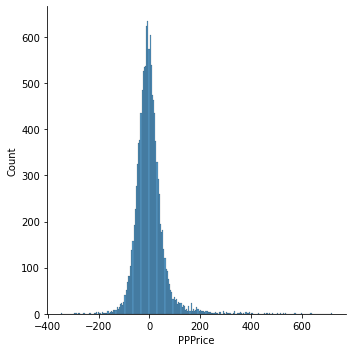

In [117]:
residuos = y_train - model.predict(X_train)
sns.displot(residuos)
print( 'excess kurtosis of normal distribution (should be 0): {}'.format( kurtosis(residuos) ))
print( 'skewness of normal distribution (should be 0): {}'.format( skew(residuos) ))

#### box-cox - ridge

In [118]:
l = -0.1
model = Ridge(alpha=10)
model.fit(X_train, box_cox(y_train,l))
y_pred = model.predict(X_val)
mape(y_val,inv_box_cox(y_pred,l))


12.194139468345897

excess kurtosis of normal distribution (should be 0): 3.2326782769178184
skewness of normal distribution (should be 0): 0.7646348850414239


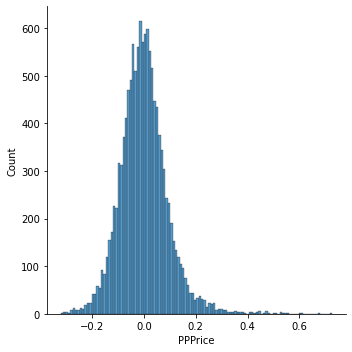

In [119]:
residuos = box_cox(y_train,l) - model.predict(X_train)
sns.displot(residuos)
print( 'excess kurtosis of normal distribution (should be 0): {}'.format( kurtosis(residuos) ))
print( 'skewness of normal distribution (should be 0): {}'.format( skew(residuos) ))

# Validación Cruzada

In [120]:
import sklearn
from sklearn.model_selection import cross_validate

In [121]:
scores_RL = cross_validate(LinearRegression(), X, y,scoring='neg_mean_absolute_percentage_error', cv=32)
scores_Las = cross_validate(Lasso(alpha=1.0), X, y,scoring='neg_mean_absolute_percentage_error', cv=32)
scores_Ri = cross_validate(Ridge(alpha=1.0), X, y,scoring='neg_mean_absolute_percentage_error', cv=32)

In [122]:
scores_reg_lin = scores_RL['test_score']*(-100)
scores_reg_lin = scores_reg_lin[scores_reg_lin < 40 ] 
scores_reg_lass = scores_Las['test_score']*(-100)
scores_reg_lass = scores_reg_lass[scores_reg_lass < 40 ] 
scores_reg_ridge = scores_Ri['test_score']*(-100)
scores_reg_ridge = scores_reg_ridge[scores_reg_ridge < 40 ] 

In [123]:
print('Los resultados para cada modelo como rendiento promedio en MAPE son; Regresion Lineal: ', scores_reg_lin.mean(), ' Lasso: ',scores_reg_lass.mean(), ' Ridge: ',scores_reg_ridge.mean())

Los resultados para cada modelo como rendiento promedio en MAPE son; Regresion Lineal:  12.973495223067312  Lasso:  16.661769076278915  Ridge:  13.038440458560201


## Validacion de parametros 

Haciendo uso del modelo OLS que dio el mejor rendimiento en la validacion cruzada procedemos a hallar el mejor parametro para box cox

In [124]:
from sklearn.model_selection import KFold

In [125]:
X_=np.array(X)
y_=np.array(y)

In [126]:
rendimiento=[]
params=np.linspace(0.1, 1.0, num=10)
for l in params:
    rend=[]
    kf = KFold(n_splits=10)
    kf.get_n_splits(X_)
    for train_index, val_index in kf.split(X_):
        X_train, X_val = X_[train_index], X_[val_index]
        y_train, y_val = y_[train_index], y_[val_index]
        model = Lasso(alpha= l)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        rend.append(mape(y_val,y_pred))
    rendimiento.append((l,np.mean(rend)))

In [127]:
rendimiento

[(0.1, 14.36875986480285),
 (0.2, 14.898852188331835),
 (0.30000000000000004, 15.28958240893914),
 (0.4, 15.5976040241894),
 (0.5, 15.84703342331809),
 (0.6, 16.078468115111285),
 (0.7000000000000001, 16.28094134291772),
 (0.8, 16.42657128744178),
 (0.9, 16.543390547047096),
 (1.0, 16.661204071380304)]

In [128]:
rendimiento=[]
params=np.linspace(0.1, 10.0, num=10)
for l in params:
    rend=[]
    kf = KFold(n_splits=10)
    kf.get_n_splits(X_)
    for train_index, val_index in kf.split(X_):
        X_train, X_val = X_[train_index], X_[val_index]
        y_train, y_val = y_[train_index], y_[val_index]
        model = Ridge(alpha= l)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        rend.append(mape(y_val,y_pred))
    rendimiento.append((l,np.mean(rend)))

In [129]:
rendimiento

[(0.1, 13.060752018257011),
 (1.2000000000000002, 13.07479587636917),
 (2.3000000000000003, 13.129551459785333),
 (3.4000000000000004, 13.181573999559655),
 (4.5, 13.230916227537445),
 (5.6, 13.275465311997683),
 (6.7, 13.316549544858608),
 (7.800000000000001, 13.354833596322127),
 (8.9, 13.391100771516577),
 (10.0, 13.425906017809249)]

# Submit

In [116]:
test=datos_test.drop(['Unnamed: 0','Itinerary','Destination',
                            'Package Name','Places Covered',
                            'Travel Date','Hotel Details','Start City',
                            'Airline',
                            'Package Type','Cancellation Rules','Quarter','paquete',
                             'Meals','Sightseeing Places Covered','ano','mes','hotel_qual_prom','Rule 2','Rule 3',
                           'Rule 4','Rule 5','Rule 6','Rule 7',
                           'Rule 8','2021','Q1','Q2','Q3',' Gwalior fort ',
                           'Budget',' Delhi to Udaipur by Bus (Departure between 5 pm - 10 pm) ' ,' Dinner at Rambagh Palace - MMT ',' Udaipur to Delhi by Bus (Departure between 5 pm - 10 pm) '],axis=1)

In [117]:
test['dest_num_square']=test['dest_numb']**2

In [118]:
test['total_noches_sqr']=(test['total_noches'])**(1/2)

In [119]:
test['noches_pond_hotel_log']=np.log(test['noches_pond_hotel'])

In [124]:
reg = LinearRegression().fit(X, box_cox(y,-0.1))
y_pred = reg.predict(test)
y_pred=inv_box_cox(y_pred,-0.1)

In [125]:
submit = pd.read_csv("sample_submission.csv")

In [126]:
submit['PPPrice']=y_pred
submit.set_index('Index',inplace = True)


In [127]:
submit

,PPPrice
Index,
7798,249.167459
1788,215.742205
2084,285.385473
18361,207.336473
13939,425.103112
...,...
19911,436.588389
13668,261.024941
12168,206.967097


In [128]:
submit.to_csv('sample_submission_total_final.csv')